In [1]:
# Current directory
import os
os.chdir('F:/One/ACP')

### Loading Data

In [2]:
import numpy as np
import pandas as pd


# train
train_features = pd.read_csv("features_label/train.csv", index_col=False, header=None)
train_labels = pd.read_csv("features_label/train_label.csv", index_col=False, header=None)
# test
test_features = pd.read_csv("features_label/test.csv", index_col=False, header=None)
test_labels = pd.read_csv("features_label/test_label.csv", index_col=False, header=None)

print('train_features:', train_features.shape)
print('train_labels', train_labels.shape)
print('test_features', test_features.shape)
print('test_labels', test_labels.shape)


train_features = np.array(train_features)
train_labels = np.array(train_labels)
test_features = np.array(test_features)
test_labels = np.array(test_labels)


train_features: (1378, 320)
train_labels (1378, 1)
test_features (344, 320)
test_labels (344, 1)


### Loading the model

In [3]:
import math
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Flatten
from keras.models import Sequential
from keras.optimizers import adam_v2
from keras.layers import Dense,Dropout
from sklearn.preprocessing import scale
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D, Dense,AveragePooling1D
from sklearn.metrics import confusion_matrix, roc_curve, auc


# model
def CNN(input_dim, out_dim, learning_rate=0.001):
    model = Sequential()
    model.add(Conv1D(filters = 64, kernel_size = 3, padding = 'same', activation= 'relu'))
    model.add(AveragePooling1D(pool_size=2,strides=1,padding="SAME"))
    model.add(Conv1D(filters = 64, kernel_size =  3, padding = 'same', activation= 'relu'))
    model.add(AveragePooling1D(pool_size=2,strides=1,padding="SAME"))
    model.add(Flatten())
    model.add(Dense(int(32), activation = 'relu'))
    model.add(Dense(out_dim, activation = 'softmax',name="Dense_2"))
    model.compile(loss = 'binary_crossentropy', optimizer = adam_v2.Adam(learning_rate), metrics =['accuracy'])
    return model


def categorical_probas_to_classes(p):
    return np.argmax(p, axis=1)


def to_categorical(y, nb_classes=None):
    y = np.array(y, dtype='int')
    if not nb_classes:
        nb_classes = np.max(y)+1
    Y = np.zeros((len(y), nb_classes))
    for i in range(len(y)):
        Y[i, y[i]] = 1
    return Y


### Training and prediction

#### Independence test

In [36]:
# Create a directory to save the model
model_save_dir = 'save_models/CNN/Independence'
os.makedirs(model_save_dir, exist_ok=True)

In [4]:
[sample_num, input_dim] = np.shape(train_features)
X_train = np.reshape(train_features, (-1,1,input_dim))
y_train = train_labels
X_test = np.reshape(test_features, (-1,1,input_dim))
y_test = test_labels
out_dim=2

ACC_collecton = []
BACC_collecton = []
Sn_collecton = []
Sp_collecton = []
MCC_collecton = []
AUC_collecton = []
AP=[]

mean_recall = np.linspace(0, 1, 100)
all_precision = []
base_fpr = np.linspace(0, 1, 100)
mean_tpr = 0.0
interp_tpr_collection = []

losses = []  # Used to store the loss value of each fold
for i in range(2):
    # dataset
    y_train_whole = to_categorical(y_train)
    
    clf = CNN(input_dim, out_dim, 0.001)
    hist = clf.fit(X_train, y_train_whole, batch_size=64, epochs=120)

    # save model
    # model_path = os.path.join(model_save_dir, f'ESM_{i}.h5')
    # clf.save(model_path)
    # print(f'Model for fold {i+1} saved at {model_path}')

    losses.append(hist.history['loss'])  # Record the loss value of each epoch

    y_score = clf.predict(X_test)
    y_class = categorical_probas_to_classes(y_score)
    TP, FP, FN, TN = confusion_matrix(y_test, y_class).ravel() # shape [ [True-Positive, False-positive], [False-negative, True-negative] ]
    Sn_collecton.append(TP/(TP+FN))
    Sp_collecton.append(TN/(TN+FP))
    MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)
    MCC_collecton.append(MCC)
    BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))
    ACC = (TP+TN)/(TP+TN+FP+FN)
    ACC_collecton.append(ACC)
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    interp_tpr = np.interp(base_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tpr_collection.append(interp_tpr)
    auc_roc = auc(fpr, tpr)
    AUC_collecton.append(auc_roc)
    # PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_score[:, 1])
    average_precision = average_precision_score(y_test, y_score[:, 1])
    recall = np.flipud(recall)
    precision = np.flipud(precision)

    mean_precision = np.interp(mean_recall, recall, precision)
    all_precision.append(mean_precision)
    AP.append(average_precision)


# After all cross-validation cycles are completed, the mean TPR is calculated.
mean_tpr = np.mean(interp_tpr_collection, axis=0)
mean_tpr[-1] = 1.0

# Calculate the mean precision
mean_precision = np.mean(all_precision, axis=0)

# Output
results = [
    f"ACC: {round(statistics.mean(ACC_collecton), 3)} ± {round(statistics.stdev(ACC_collecton), 3)}",
    f"BACC: {round(statistics.mean(BACC_collecton), 3)} ± {round(statistics.stdev(BACC_collecton), 3)}",
    f"Sn: {round(statistics.mean(Sn_collecton), 3)} ± {round(statistics.stdev(Sn_collecton), 3)}",
    f"Sp: {round(statistics.mean(Sp_collecton), 3)} ± {round(statistics.stdev(Sp_collecton), 3)}",
    f"MCC: {round(statistics.mean(MCC_collecton), 3)} ± {round(statistics.stdev(MCC_collecton), 3)}",
    f"AUC: {round(statistics.mean(AUC_collecton), 3)} ± {round(statistics.stdev(AUC_collecton), 3)}",
    f"AP: {round(statistics.mean(AP), 3)} ± {round(statistics.stdev(AP), 3)}"
]

for result in results:
    print(result)

# Append the results to the file
with open('result/results_CNN.txt', 'a') as file:
    file.write("----------------------------------------\n")
    for result in results:
        file.write(result + '\n')


Epoch 1/120
22/22 [==============================] - 6s 8ms/step - loss: 0.6808 - accuracy: 0.5943
Epoch 2/120
22/22 [==============================] - 0s 4ms/step - loss: 0.6293 - accuracy: 0.6553
Epoch 3/120
22/22 [==============================] - 0s 4ms/step - loss: 0.5925 - accuracy: 0.6705
Epoch 4/120
22/22 [==============================] - 0s 4ms/step - loss: 0.5718 - accuracy: 0.7039
Epoch 5/120
22/22 [==============================] - 0s 4ms/step - loss: 0.5535 - accuracy: 0.7061
Epoch 6/120
22/22 [==============================] - 0s 4ms/step - loss: 0.5435 - accuracy: 0.7192
Epoch 7/120
22/22 [==============================] - 0s 4ms/step - loss: 0.5285 - accuracy: 0.7235
Epoch 8/120
22/22 [==============================] - 0s 4ms/step - loss: 0.5348 - accuracy: 0.7155
Epoch 9/120
22/22 [==============================] - 0s 4ms/step - loss: 0.5221 - accuracy: 0.7293
Epoch 10/120
22/22 [==============================] - 0s 4ms/step - loss: 0.5058 - accuracy: 0.7475
Epoch 11/

In [ ]:
# 绘制ROC曲线
plt.figure()
lw = 2
plt.plot(base_fpr, mean_tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % np.mean(AUC_collecton))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Independence test')
plt.legend(loc="lower right")
plt.tight_layout()
# plt.savefig('loss_curve.png', dpi=300)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


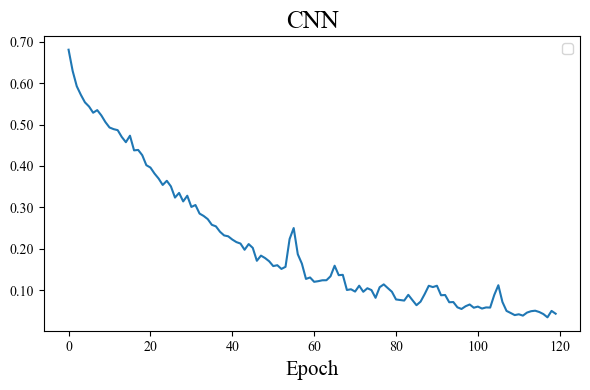

In [9]:
# 绘制损失函数曲线
from matplotlib.ticker import FuncFormatter


# 字体设置
plt.rcParams['font.family'] = 'Times New Roman'

n = 0
loss = losses[n]
plt.figure(figsize=(6, 4))

plt.plot(loss)
# for i, loss in enumerate(losses):
#     plt.plot(loss, label=f'Fold {i+1}')

formatter = FuncFormatter(lambda x, pos: f'{x:.2f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('', fontsize=15)
plt.title('CNN', fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig('graph\Loss\ACP_CNN_120.jpeg', dpi=300)
plt.show()


### 结尾